# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [94]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch
!pip install wandb

# 引用依赖包

In [95]:
%config Completer.use_jedi = False

In [96]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## U-Net 网络

In [97]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

sigmoid = nn.Sigmoid()
if torch.cuda.is_available():
    sigmoid = sigmoid.cuda()

class UNet(nn.Module):
    def __init__(self, input_channels, num_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.input_channels = input_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(input_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, num_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        out = self.outc(x)
        if not self.training:
            out = sigmoid(out)
            out = torch.where(out>0.5,torch.ones_like(out),torch.zeros_like(out))
        return out

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [98]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        img_paths = list(Path(img_dir).glob("*"))
        mask_paths = list(Path(mask_dir).glob("*"))
        self.images = []
        self.masks = []
        for img_idx in range(len(img_paths)):
            img_path = img_paths[img_idx]
            img = self.load_image(img_path)
            num_channels = len(img.getbands())
            if num_channels != 3:
                continue
            
            mask_path = mask_paths[img_idx]
            self.images.append(img_path)
            self.masks.append(mask_path)
            
        # 设置 transforms
#         self.transform = transforms.Compose([ transforms.Resize(size), 
#                                              transforms.RandomHorizontalFlip(),  # 随机水平翻转
#                                              transforms.RandomVerticalFlip(),    # 随机垂直旋转
#                                              transforms.RandomRotation(10) ,     # 随机旋转 （-10,10）度
#                                              transforms.ToTensor()])
        
        self.transform = transforms.Compose([ v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),  # 随机水平翻转
                                             v2.RandomVerticalFlip(),    # 随机垂直旋转
                                             v2.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
#                                              v2.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    def load_image(self, path) -> Image.Image:
        "Opens an image via a path and returns it."
        return Image.open(path)
    
    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)
    
    #  CutMix 的切块功能
 
    def rand_bbox(self, size, lam):
        W = size[1]
        H = size[2]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_image(self.images[index])
        mask_img = self.load_image(self.masks[index])
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
        
        mask_img = torch.where(mask_img>0.5,torch.ones_like(mask_img),torch.zeros_like(mask_img))
        
        
        
        rand_index = random.randint(0, len(self)-1)
        rand_orig_img = self.load_image(self.images[rand_index])
        rand_mask_img = self.load_image(self.masks[rand_index])
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        rand_orig_img = self.transform(rand_orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        rand_mask_img = self.transform(rand_mask_img)
        
        rand_mask_img = torch.where(rand_mask_img>0.5,torch.ones_like(rand_mask_img),torch.zeros_like(rand_mask_img))
        
        lam = np.random.beta(1., 1.)
        rand_index = torch.randperm(len(self)).cuda()
        bbx1, bby1, bbx2, bby2 = self.rand_bbox(mask_img.size(), lam)
        
        
        
        orig_img[:, bbx1:bbx2, bby1:bby2] = rand_orig_img[:, bbx1:bbx2, bby1:bby2]
        mask_img[:, bbx1:bbx2, bby1:bby2] = rand_mask_img[:, bbx1:bbx2, bby1:bby2]
        
        return orig_img, mask_img


## 定义训练和验证的方法

In [99]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp, experiment):
    net.eval()
    
    num_val_batches = len(dataloader)
    bce_loss = 0
    dice_loss = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        num_classes = net.module.num_classes
    else:
        num_classes = net.num_classes
    
    # 因为在非训练过程（推理过程中），已经在网络最后一层加了log和过滤
    # 因此这里的损失函数都要使用不带log的
    criterion = nn.BCELoss().cuda()
    diceloss = smp.losses.DiceLoss(mode='binary', from_logits=False).cuda()
    
    # iterate over the validation set
    with tqdm(total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True) as pbar:
        for batch in dataloader:

            images, mask_true = batch

            # move images and labels to correct device and type
            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(images)
            bce_loss += criterion(mask_pred, mask_true.float())
            dice_loss += diceloss(mask_pred, mask_true)

            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)

            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            pbar.update(images.shape[0])

        bce_loss = (bce_loss / max(num_val_batches, 1))
        dice_loss = (dice_loss / max(num_val_batches, 1))

        iou_score = (iou_score / max(num_val_batches, 1))
        pbar.set_postfix(**{"Validation bce loss": bce_loss.item(), "dice loss": dice_loss.item(), "IoU Score": iou_score.item()})
    
    try:
        histograms = {}
        for tag, value in net.named_parameters():
            tag = tag.replace('/', '.')
            if not (value is None) and not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
            if not (value.grad is None) and not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

        experiment.log({
            'validation Loss': bce_loss + dice_loss,
            'validation IoU Score': iou_score,
            'images': wandb.Image(images[0].cpu()),
            'masks': {
                'true': wandb.Image(mask_true[0].float().cpu()),
                'pred': wandb.Image(mask_pred[0].float().cpu()),
            },
            **histograms
        })
    except Exception as e:
        print(e)
        pass
    
    return (dice_loss, iou_score)    
    

In [100]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

def train(model, device, project,
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 6,
          amp: bool = False,
          gradient_clipping: float = 1.0):
    n_train = len(train_data)
    n_val = len(validate_data)


    if isinstance(model, nn.DataParallel):
        num_classes = model.module.num_classes
        input_channels = model.module.input_channels
    else:
        num_classes = model.num_classes
        input_channels = model.input_channels
        

    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must', notes='水平和垂直翻转，旋转(-10,10)度，mixcut')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, amp=True)
    )
    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice scor
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    # 训练过程中，网络最后一层没有添加log，所以要使用带log的损失函数
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True).cuda()

    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='batch') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == input_channels, \
                    f'Network has been defined with {input_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': epoch_loss/n_train})
                if global_step % 10 == 0:
                    experiment.log({
                        'learning rate': optimizer.param_groups[0]['lr'],
                        'train iou': iou_score,
                        'train loss': loss.item(),
                        'step': global_step,
                        'epoch': epoch
                    })
                

           # Evaluation round
                division_step = (n_train // batch_size)
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score, iou_score = evaluate(model, valloader, device, amp, experiment)
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()


## 添加 MixCut 和 MixUp
> https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#as-part-of-the-collation-function

In [101]:
# print(torch.__version__)
# from torchvision.transforms import v2
# from torch.utils.data import default_collate
# NUM_CLASSES = 1
# cutmix = v2.CutMix(num_classes=NUM_CLASSES)
# mixup = v2.MixUp(num_classes=NUM_CLASSES)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

# def collate_fn(batch):
#     return cutmix_or_mixup(*default_collate(batch))


# 加载数据集

In [102]:
batch_size=8
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])
total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=batch_size,
                                     num_workers=0,
                                     shuffle=True)
#                                      collate_fn=collate_fn)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)
#                                     collate_fn=collate_fn)

dataset info
total: 572, train_size: 457, validate_size: 115


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
showing image of 158: 


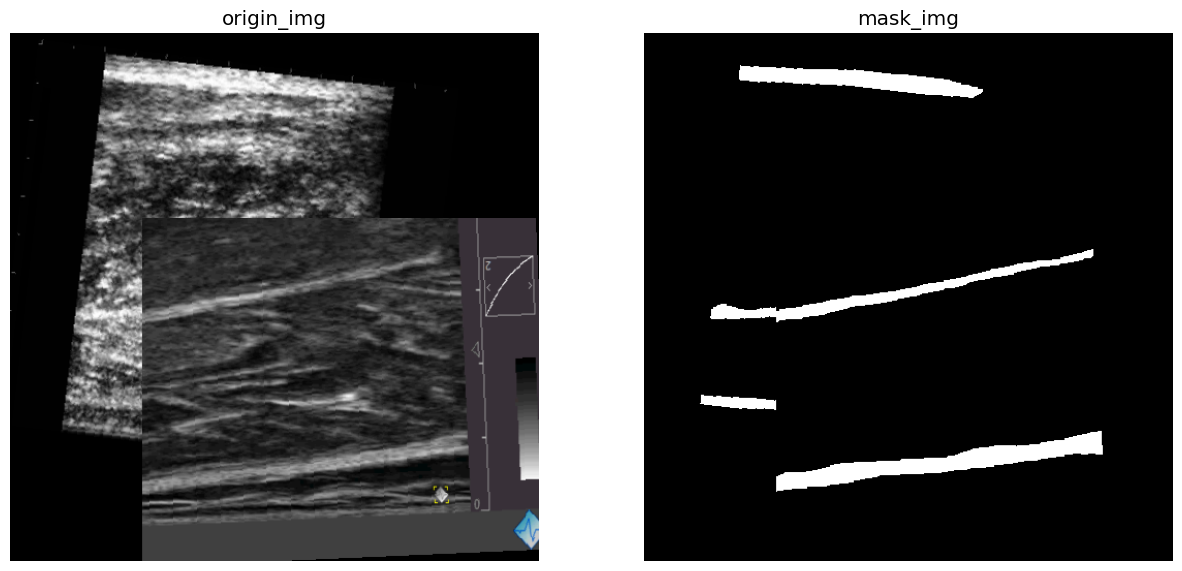

In [103]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]

print(orig_img.size())
print(mask_img.size())


print("showing image of {}: ".format(idx))

orig_img = orig_img.cpu().numpy().transpose(1, 2, 0)
mask_img = mask_img.cpu().numpy().transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.grid(False)
ax1.axis('off')
ax1.set_title("origin_img")

ax2.imshow(mask_img, cmap="gray")
ax2.grid(False)
ax2.axis('off')
ax2.set_title("mask_img")

plt.show()

# 训练网络

## 设置wandb账号
用作统计与数据分析

In [104]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [ ]:
epochs=100
if __name__ == '__main__':
    model = UNet(input_channels=3, num_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device, project="U-Net", epochs=epochs, batch_size=batch_size)

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

epoch,▁
learning rate,▁
step,▁
train iou,▁
train loss,▁
epoch,1
learning rate,1e-05
step,10
train iou,0.08588
train loss,1.51007


Epoch 4/100:  91%|█████████ | 416/457 [01:17<00:07,  5.31batch/s, loss (batch)=0.127] 

# 推理